# Run only once

In [1]:
data_path = '/content/drive/My Drive/Simulations in Stat learning/data/'
distributions_path = '/content/drive/My Drive/Simulations in Stat learning/distributions/'
videos_path = '/content/drive/My Drive/Simulations in Stat learning/videos/2/'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-sil-gentiumplus fonts-sil-gentiumplus-compact
  fonts-stix fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcups

In [3]:

import matplotlib
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}\usepackage{amsfonts}\usepackage{bm}']
from matplotlib.lines import Line2D

import numpy as np

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib
%matplotlib inline
from scipy.stats import multivariate_normal
import pickle
import os

In [4]:
np.random.seed(42)
#Standard
rc = {
        "xtick.bottom" : True,
        "xtick.labelbottom" : True,
        "xtick.labelsize" : 12,
        'xtick.major.pad' : '7',
        "ytick.labelleft" : True,
        "ytick.labelsize" : 12,
        'ytick.major.pad' : '7',
        "ytick.left" : True,
        "figure.figsize" : (24,18),
        'axes.linewidth' : 7,
        "axes.facecolor": 'white',
        'savefig.facecolor':'blue',
        'text.usetex' : True,

        }
plt.rcParams.update(rc)

## Supporting Functions

In [5]:
import math
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

In [6]:
#CUSTOM COLORMAPS

label_colors = matplotlib.colors.ListedColormap(['silver', 'Black'])
right_wrong_colors = matplotlib.colors.ListedColormap(['tomato', 'forestgreen'])
hypothesis_colors = matplotlib.colors.ListedColormap(['tomato', 'silver'])


In [7]:
#norm = colors.Normalize(0, 1)
def get_facecolors(array,mode,alpha = 1):
    shape = array.shape
    p = (-1,)
    if mode == "red":
        colors = right_wrong_colors(array.reshape(-1),alpha)
    if mode == "hypothesis":
        colors = hypothesis_colors(array.reshape(-1),alpha)


    if mode == "black":
        
        #colors = cm.binary(array.reshape(-1),alpha)
        colors = label_colors(array.reshape(-1),alpha)
        
        
    return colors.reshape(shape + p)

In [8]:
#This get labels is slightly different from the one in hoeffdings inequality notebook
def get_labels(x,y,distribution):
    if distribution == "circle":
        z = np.where(x**2 + y**2 + 2*0.9*x + 2*0.5*y - 0.2 > 0 , 1 , 0)  
        
    elif distribution == "linear":
        h_labeling = np.array([0.7,0.5])
        
        temp = np.c_[x,y]   #---for animation
        z = np.where(np.matmul(temp,h_labeling) - 0> 0.0, 1, 0)
        
    elif distribution =="wiggly1":
        z = np.where(3*y**3 +x**2 -0.2*y**2 +  0*x - 0.01   >0, 1, 0)
        
    elif distribution =="wiggly2":
        z = np.where(30*x**10 + 2*y**10 -700*x**7 + 20*y**5 -1*x**2 + 0.02   >0, 0, 1)
        
    elif distribution == "l1":
        z1 = np.where(abs(x)+abs(y)>0.15,1,0)
        z2 = np.where(abs(x)+abs(y)>0.4,1,0)

        z = np.logical_xor(z1,z2)
    
    else :
        filename = distributions_path + distribution + ".png"
        im = plt.imread(filename)
        image = np.round(np.sum(im,2)/3)

        x_ = np.floor((x + 0.4)*1000)
        y_ = np.floor((y + 0.4)*1000)

        labels = []
        for i,j in zip(x_.astype(int),y_.astype(int)):

            label = image[i,j]
            labels.append(label)

        z = np.abs(1 - np.array(labels))
    
    
        
    return z

In [9]:
def errors_on_hypothesis_set(data,hypothesis):
    intermediate = np.matmul(data[:,:2], hypothesis)
    predictions = np.where(intermediate > 0.0, 1, 0)
    labels = data[:,2]

    E_out = np.logical_xor(predictions.T,labels)
    true_errors = 1 - np.sum(E_out,axis=1)/E_out.shape[1]
    
    return true_errors,E_out,predictions #this depends on which all hypothesis I want to animate on

__________________________________________________________________________________________________________________

# KNOBS

In [10]:
#NO VARIABLES...

###################################
highlighted_hypothesis = 1 #this is what erm selected when hypothesis class was of size 4.


true_distribution_visible = True

black_white_mode = False
interpolation_mode = "iid"  #iid, continuous



sample_size_to_animate_on = 300  #,200,400
epsilon = 0.1
all_8 = True
find_points = False
if interpolation_mode == "continuous":
  find_points = False



In [11]:
# Importing shit from the hoeffdings inequality notebook
os.chdir(data_path)

constants = []
PIK = "pickle.dat"
with open(PIK, "rb") as f:
    for _ in range(pickle.load(f)):
        constants.append(pickle.load(f))

true_unknown_distribution = constants[1]
is_agnostic = constants[2]

specific_hypothesis = highlighted_hypothesis

# All the knobs

In [12]:
#PAC LEARNING
#All the knobs here
n = sample_size_to_animate_on
distribution = true_unknown_distribution
agnostic = is_agnostic
#interpolation_type = 

if agnostic:
  name = "agnostic"
else:
  name = distribution



e = epsilon
vc_dim = 2

# CHANGE THIS TO CHANGE HYPOTHESIS CLASS..
hypothesis = np.random.uniform(-1,1,[2,10000])
h4 = np.array([[0,-0.5],
               [-0.5,0],   #the best hypothesis in this toy class..      Interpolate the hypothesis for this h_erm..
               [0.5,0],
               [0,0.5],
                ])
hypothesis[:,:4] = h4.T









data = np.load(data_path + "data_"+name+'_'+str(40000)+".npy")
training_data = np.load(data_path + "training_data_"+name+'_'+str(500)+".npy")


training_data = training_data[:n,:]

#No free lunch shit
#data = training_data[:2,:]
#training_data = np.c_[training_data[0,:],training_data[0,:]].T

#Useful when saving file

if true_distribution_visible == False:
  name = name + "_training_only_"


# do big matrix multiplications


In [13]:

true_errors,E_out,p_true = errors_on_hypothesis_set(data,hypothesis)
in_sample_errors,E_in,_ = errors_on_hypothesis_set(training_data,hypothesis)


In [14]:
h_erm = np.argmin(in_sample_errors)
x = hypothesis[0,h_erm]
y = hypothesis[1,h_erm]

In [34]:
in_sample_errors[563]

0.06333333333333335

In [15]:


E_out = E_out[:4,:]
p_true = p_true[:,:4]


___________________________________________________________________________________________________________________________

# Plotting

Text(-1.22, -1.53, 'The data scientist chooses a (toy) hypothesis class which, they believe, contains\n a hypothesis with a low true error. A point in this space is a particular setting\n of weight 1 and weight 2. For simplicity, bias is fixed at 0.')

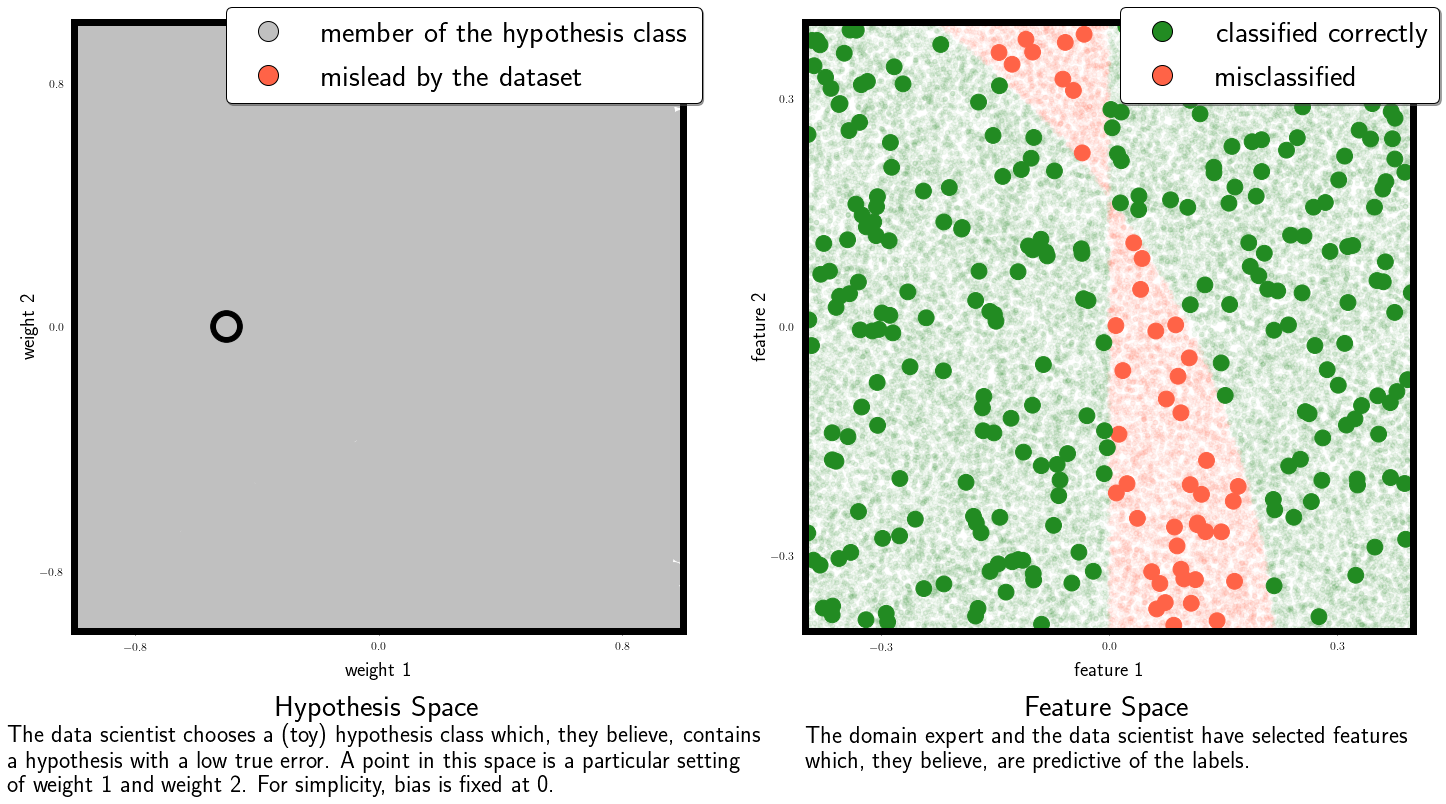

In [16]:
#Formatting the plot
fig, axs = plt.subplots(1, 2)
plt.autoscale(False)


axs[0].set_xlim([-0.4, 0.4])
axs[0].set_ylim([-0.4, 0.4])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[0].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[0].set_aspect(aspect='equal', adjustable='box')

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-1, 1])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[1].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[1].set_aspect(aspect='equal', adjustable='box')

# Now we'll swap their positions after they've been created.
pos1 = axs[1].get_position()
axs[1].set_position(axs[0].get_position())
axs[0].set_position(pos1)



#When animating the hypothesis I need to have a reference over this
if true_distribution_visible: #Fix this, hypothesis does not get highlighted when the distribution is not visible

  data_labels = axs[0].scatter(data[:,0],data[:,1],c=right_wrong_colors(E_out[highlighted_hypothesis,:],0.05),s = 20)
  training_data_labels   = axs[0].scatter(training_data[:,0],training_data[:,1],c=right_wrong_colors(E_in[highlighted_hypothesis,:],1),s = 250)


   #2 is the hypothesis which is highlighted
  diff = np.abs(true_errors - in_sample_errors)
  hypothesis_space_2 = axs[1].scatter(hypothesis[0,:],hypothesis[1,:],c = hypothesis_colors(diff<e,1),s=400)
  current_hypothesis_0 = axs[1].scatter(hypothesis[0,highlighted_hypothesis],hypothesis[1,highlighted_hypothesis],color='black',s=1000)
  current_color = axs[1].scatter(hypothesis[0,highlighted_hypothesis],hypothesis[1,highlighted_hypothesis],s=400,color = 'silver')






if black_white_mode:

    line1 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20, markerfacecolor="lightgrey")
    line2 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20,markerfacecolor="black")
    l=axs[0].legend((line1,line2),('label a','label b'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.9, 1.05),ncol=1, fancybox=True, shadow=True)
    frame = l.get_frame()
    #frame.set_facecolor('white')
    frame.set_edgecolor('black')
else:
    line1 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20, markerfacecolor="forestgreen")
    line2 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20,markerfacecolor="tomato")
    l=axs[0].legend((line1,line2),('classified correctly','misclassified'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.78, 1.05),ncol=1, fancybox=True, shadow=True)
    frame = l.get_frame()
    #frame.set_facecolor('white')
    frame.set_edgecolor('black')

if not true_distribution_visible:
    
    line1 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20, markerfacecolor="silver")
    #line2 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20,markerfacecolor="tomato")
    l=axs[1].legend([line1],[r'$ \text{member of the hypothesis class}$'],prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.64, 1.05),ncol=1, fancybox=True, shadow=True)
    #l=axs[0].legend((line1,line2),(r'$ \text{diff}<\bm{\varepsilon}$',r'$ \text{diff}>\bm{\varepsilon}$'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.9, 1.05),ncol=1, fancybox=True, shadow=True)
    frame = l.get_frame()
    frame.set_edgecolor('black')
else:
    line1 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20, markerfacecolor="silver")
    line2 = Line2D(range(1), range(1), linewidth=0,color="black", marker='o',markersize=20,markerfacecolor="tomato")
    l=axs[1].legend((line1,line2),(r'$ \text{member of the hypothesis class}$',r'$ \text{mislead by the dataset}$'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.64, 1.05),ncol=1, fancybox=True, shadow=True)
    #l=axs[0].legend((line1,line2),(r'$ \text{diff}<\bm{\varepsilon}$',r'$ \text{diff}>\bm{\varepsilon}$'),prop={'size': 30},frameon=True,loc='upper center', bbox_to_anchor=(0.9, 1.05),ncol=1, fancybox=True, shadow=True)
    frame = l.get_frame()
    frame.set_edgecolor('black')




#Caption ,title control
axs[0].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[0].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[0].set_xlabel('feature 1',fontsize = 20,labelpad=10)
axs[0].set_ylabel('feature 2',fontsize = 20,labelpad=1)
axs[0].set_title("Feature Space",y = -0.15,fontsize = 30)
txt="The domain expert and the data scientist have selected features\n which, they believe, are predictive of the labels."
axs[0].text(-0.40, -0.58, txt, ha='left',fontsize = 24)  


#text and axis labels
axs[1].xaxis.set_major_locator(plt.MaxNLocator(3))
axs[1].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[1].set_xlabel('weight 1',fontsize = 20,labelpad=10)
axs[1].set_ylabel('weight 2',fontsize = 20,labelpad=1)
axs[1].set_title("Hypothesis Space",y = -0.15,fontsize = 30)
txt="The data scientist chooses a (toy) hypothesis class which, they believe, contains\n a hypothesis with a low true error. A point in this space is a particular setting\n of weight 1 and weight 2. For simplicity, bias is fixed at 0."
#axs[1].text(-0.5, -0.616, txt, ha='left',fontsize = 24) 
axs[1].text(-1.22, -1.53, txt, ha='left',fontsize = 24) 






In [17]:
def get_linear_interpolated_points(current_points,final_points,frames):
    shape = current_points.shape
    diff = final_points.reshape(-1) - current_points.reshape(-1)
    offset = diff/frames
    interpolated_points = []
    for i in range(frames):
        points_n = current_points.reshape(-1) + offset*i
        interpolated_points.append(points_n.reshape(shape))
    return np.array(interpolated_points)

In [18]:
frames  = 60

In [19]:
point1 = np.array([hypothesis[0,highlighted_hypothesis],hypothesis[1,highlighted_hypothesis]])

In [20]:
point2 = np.array([x/2,y/2])

In [21]:
ans = get_linear_interpolated_points(point1,point2,frames).T

In [22]:
_,E_out,_ = errors_on_hypothesis_set(data,ans)
_,E_in,_ = errors_on_hypothesis_set(training_data,ans)

In [23]:
colors_background = []
colors_sample = []

for i in range(frames):
  colors_background.append(right_wrong_colors(E_out[i,:],0.05))
  colors_sample.append(right_wrong_colors(E_in[i,:],1))

colors_background = np.array(colors_background)
colors_sample = np.array(colors_sample)

In [24]:
finite_hypothesis = ans

In [25]:
finite_hypothesis.shape

(2, 60)

In [26]:
point2

array([-0.48545533, -0.26896386])



# POints Animation 

In [27]:

def animate(i,colors_background,colors_sample,finite_hypothesis):
    
    data_labels.set_facecolors(colors_background[i,:,:])
    training_data_labels.set_facecolors(colors_sample[i,:,:])

    current_color.set_offsets(finite_hypothesis[:,i])
    current_hypothesis_0.set_offsets(finite_hypothesis[:,i])

    return data_labels,training_data_labels,current_hypothesis_0,current_color,

In [28]:
ani = animation.FuncAnimation(fig, animate, fargs=(colors_background,colors_sample,finite_hypothesis,),
            frames=frames, interval=10, repeat=False,blit = True) 

if all_8:
  knob = "infinite_" + "doing_erm_correction"

  file_name = "/god/" + knob


ani.save(videos_path+file_name+'.mp4', fps=30, extra_args=['-vcodec', 'libx264'],savefig_kwargs=dict(facecolor='blue'))